# Time Series EDA

- Time Series Train-Test Split
    1. Human-based
    1. Percentage Based
    1. Cross Validate Splits
- 10 Awesome Time Series Visualizations to Impress Your Friends and Family
    1. Blow off the time series
    1. y over time
    1. y averaged over various periods over time
    1. change in y over time
    1. Seasonal Plot
    1. Seasonal Subseries Plot
    1. Lag Plot
    1. Autocorrelation Plot
    1. Seasonal Decomposition
    1. Area Plots
- Aside: working with dates in matplotlib
- Aside: `strftime` ([Cheatsheet](https://zach.lol/strftime.html))

## Setup

We'll be looking at temperature data for san antonio from late 2012 to late 2017.

We'll need to convert from Kelvin to Fahrenheit.

°F = (K - 273.15) x 1.8000 + 32.00

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

url = 'https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv'
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
df.head()

df.shape[0]

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00


45252

In [2]:
df.temp.describe()

count    45252.000000
mean        69.144163
std         14.946638
min         17.420000
25%         59.810000
50%         71.661650
75%         79.412000
max        104.918000
Name: temp, dtype: float64

- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Train-Test Split

- Ideally all splits contain a season
- Human-based: use the last year as test
- Percentage based: use the last 20% as test
- Cross Validate: break data up into slices and use successive slices as train and test repeatedly (`sklearn.model_selection.TimeSeriesSplit`)
    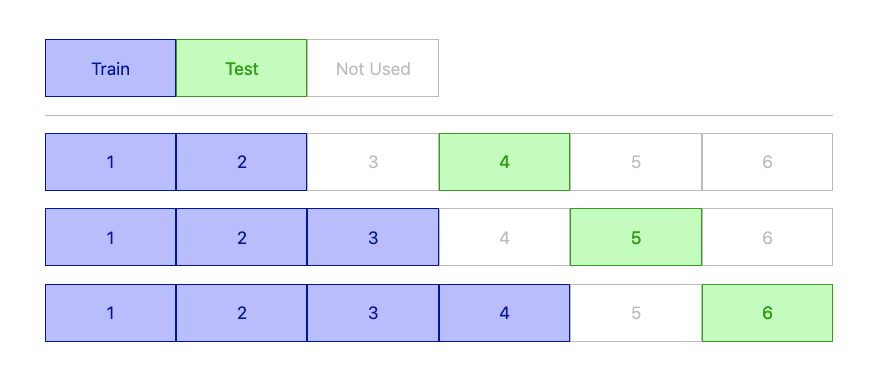

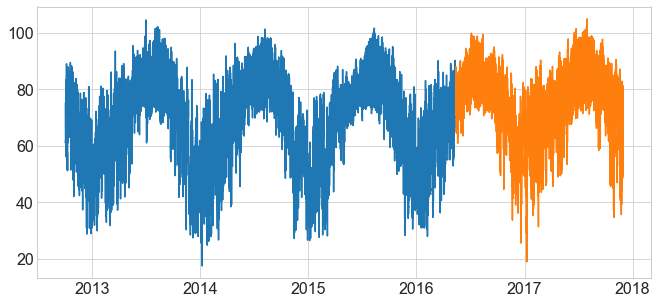

In [3]:
# Percentage-Based
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

/var/folders/_v/lfgsfb3n229bdhyjm1pj7f840000gn/T/ipykernel_84741/3389001825.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = df['2017']


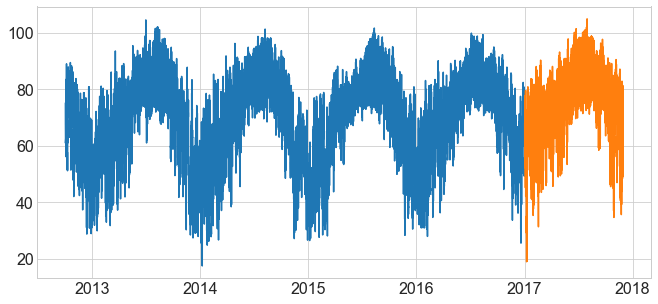

In [4]:
# Human-Based
train = df[:'2016'] # includes 2016
test = df['2017']

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

## Visualizations

In [5]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

### 1 Blow off the time series

<AxesSubplot:ylabel='Frequency'>

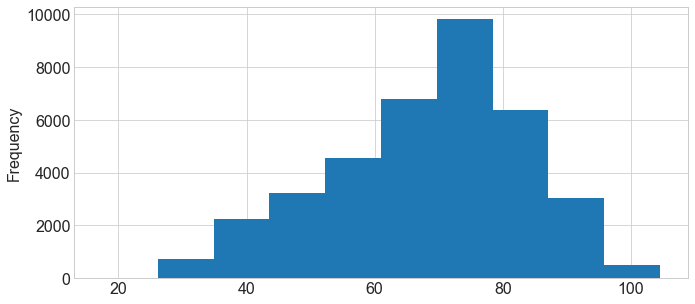

In [6]:
train.temp.plot.hist()

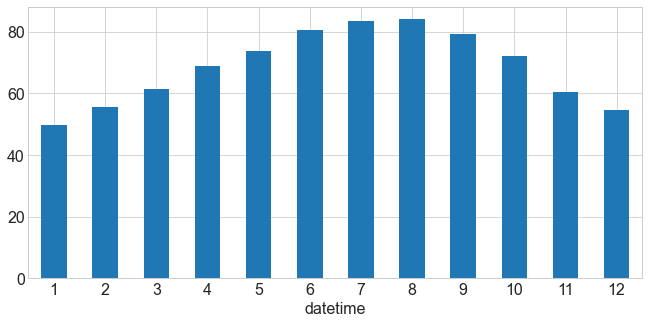

In [7]:
ax = train.groupby(train.index.month).temp.mean().plot.bar()
ax.tick_params('x', rotation=0)

/var/folders/_v/lfgsfb3n229bdhyjm1pj7f840000gn/T/ipykernel_84741/2166730346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekday'] = train.index.day_name()


<AxesSubplot:xlabel='weekday'>

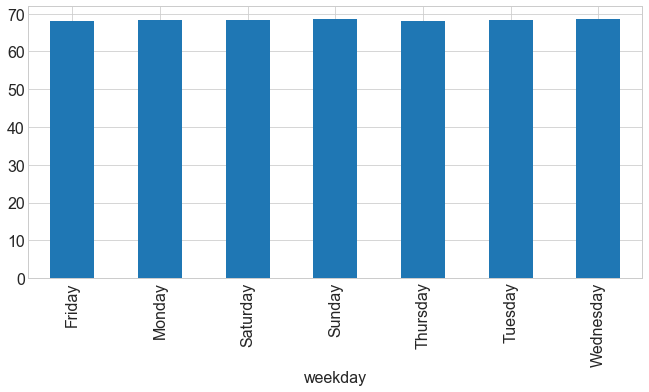

In [8]:
train['weekday'] = train.index.day_name()
train.groupby('weekday').temp.mean().plot.bar()

<AxesSubplot:xlabel='weekday', ylabel='temp'>

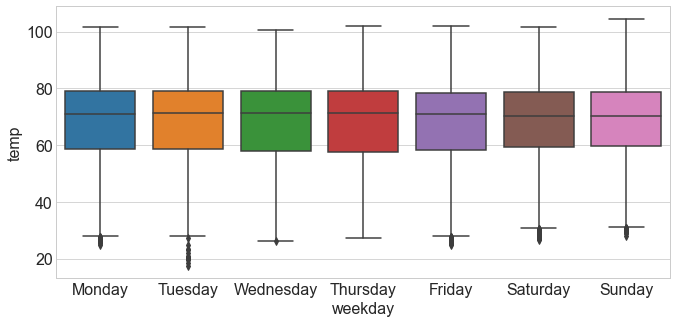

In [9]:
sns.boxplot(data=train, y='temp', x='weekday')

### 2 y over time

In [10]:
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

<AxesSubplot:xlabel='datetime'>

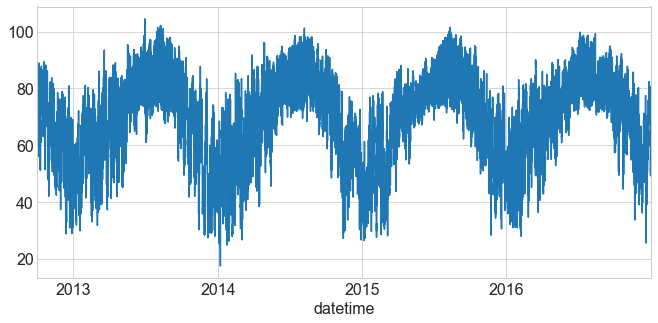

In [11]:
y.plot()

### 3 y averaged over various periods over time

<AxesSubplot:xlabel='datetime'>

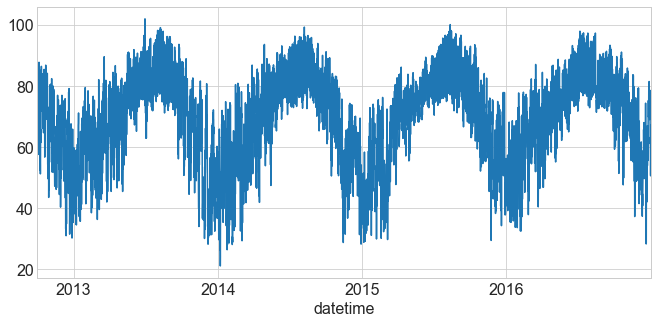

In [12]:
y.resample('6H').mean().plot()

<AxesSubplot:xlabel='datetime'>

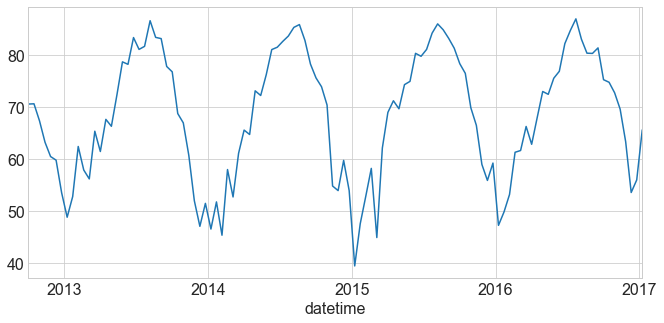

In [13]:
y.resample('2W').mean().plot()

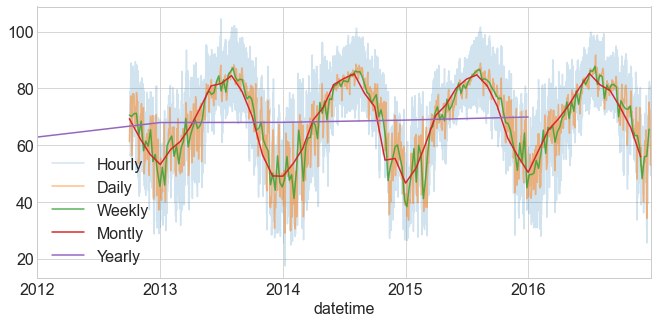

In [14]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

### 4 change in y over time

<AxesSubplot:xlabel='datetime'>

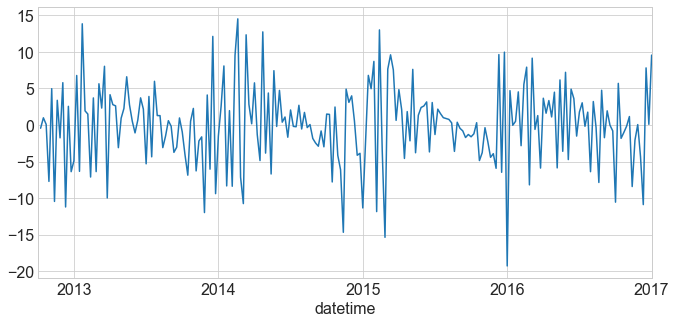

In [15]:
y.resample('W').mean().diff().plot()

[Text(0.5, 1.0, 'Temperature over time')]

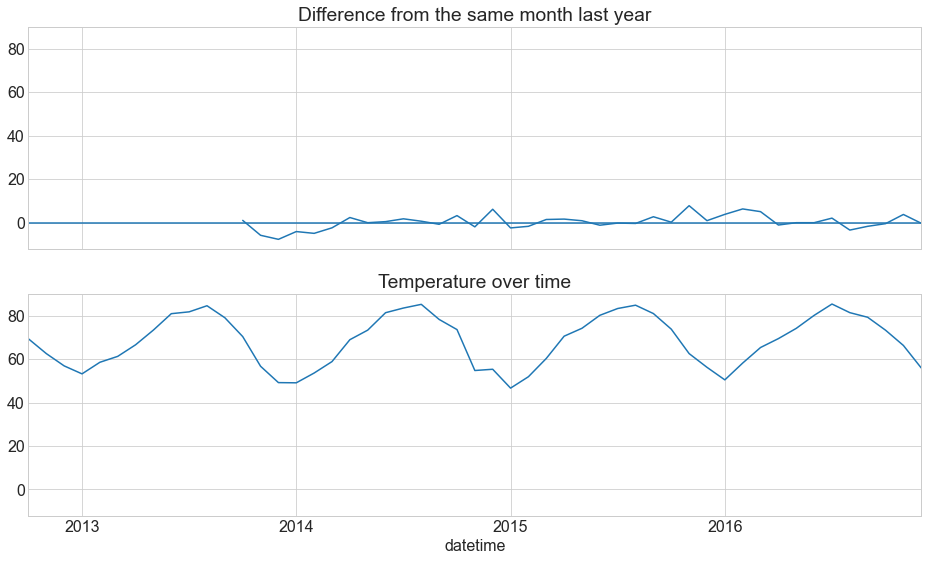

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 9))

ax = y.resample('M').mean().diff(12).plot(ax=ax1)
ax1.hlines(0, *ax1.get_xlim())
ax1.set(title='Difference from the same month last year')

y.resample('M').mean().plot(ax=ax2)
ax2.set(title='Temperature over time')

### 5 Seasonal Plot

- xaxis: month 
- yaxis: y
- color: year

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='datetime'>

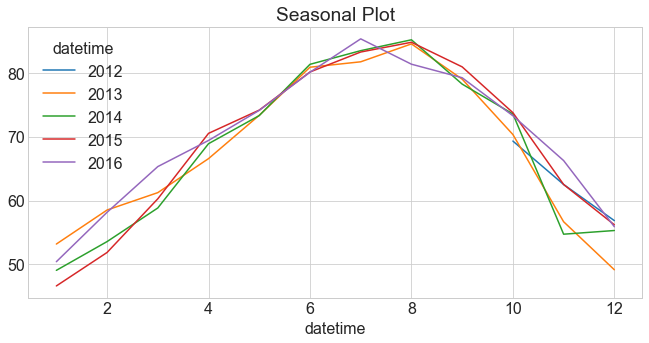

In [17]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

### 6 Seasonal Subseries Plot

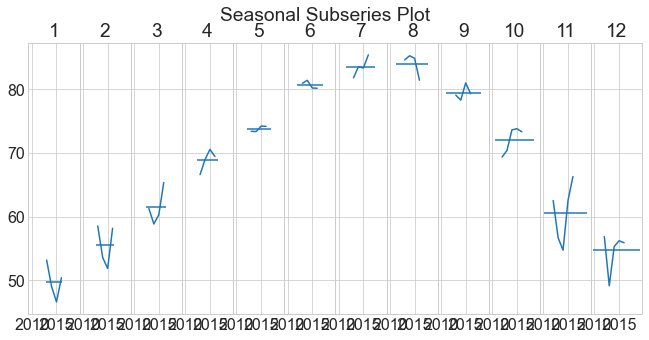

In [18]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
# fig.tight_layout()
fig.subplots_adjust(wspace=0)

### 7 Lag Plot

/var/folders/_v/lfgsfb3n229bdhyjm1pj7f840000gn/T/ipykernel_84741/2409313638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y(t + 1)'] = train.temp.shift(-1)


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

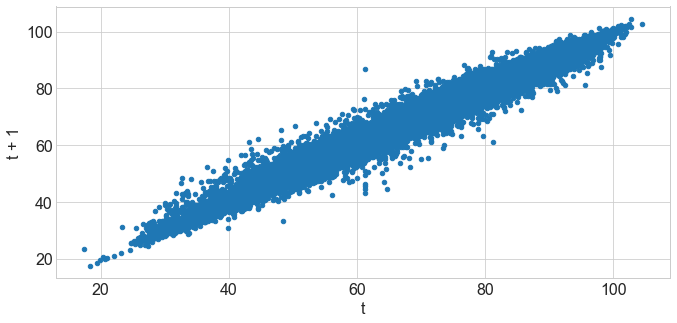

In [19]:
train['y(t + 1)'] = train.temp.shift(-1)
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

,this_week,the_next_week
datetime,,
2012-10-07,70.595201,70.152821
2012-10-14,70.152821,71.138375
2012-10-21,71.138375,71.230464
2012-10-28,71.230464,63.510554
2012-11-04,63.510554,68.482625
...,...,...
2016-12-04,59.062094,48.163625
2016-12-11,48.163625,55.979132
2016-12-18,55.979132,56.073143


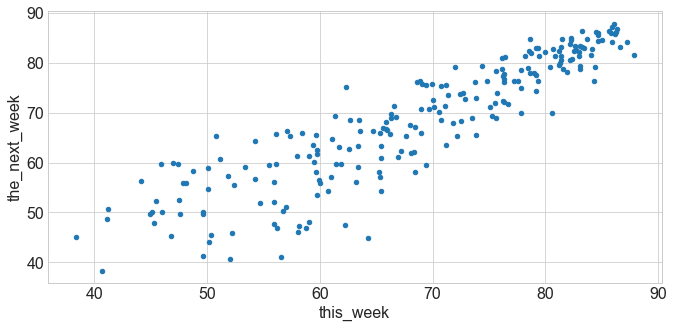

In [20]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

,this_week,8_weeks_out
datetime,,
2012-10-07,70.595201,59.638196
2012-10-14,70.152821,65.431679
2012-10-21,71.138375,54.209911
2012-10-28,71.230464,56.765589
2012-11-04,63.510554,50.376741
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


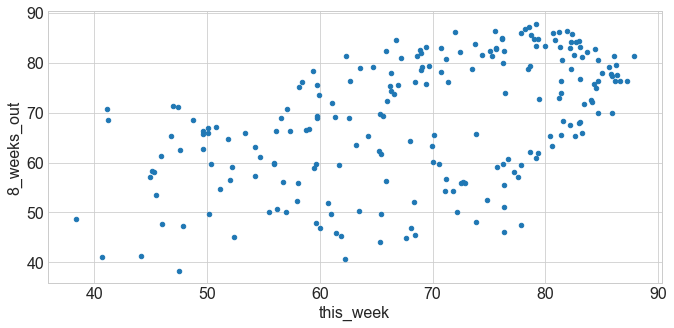

In [21]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['8_weeks_out'] = weekly.temp.shift(-8)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='8_weeks_out')
weekly

,this_week,half_a_year_later
datetime,,
2012-10-07,70.595201,63.558611
2012-10-14,70.152821,66.345532
2012-10-21,71.138375,68.965502
2012-10-28,71.230464,65.862071
2012-11-04,63.510554,66.797107
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


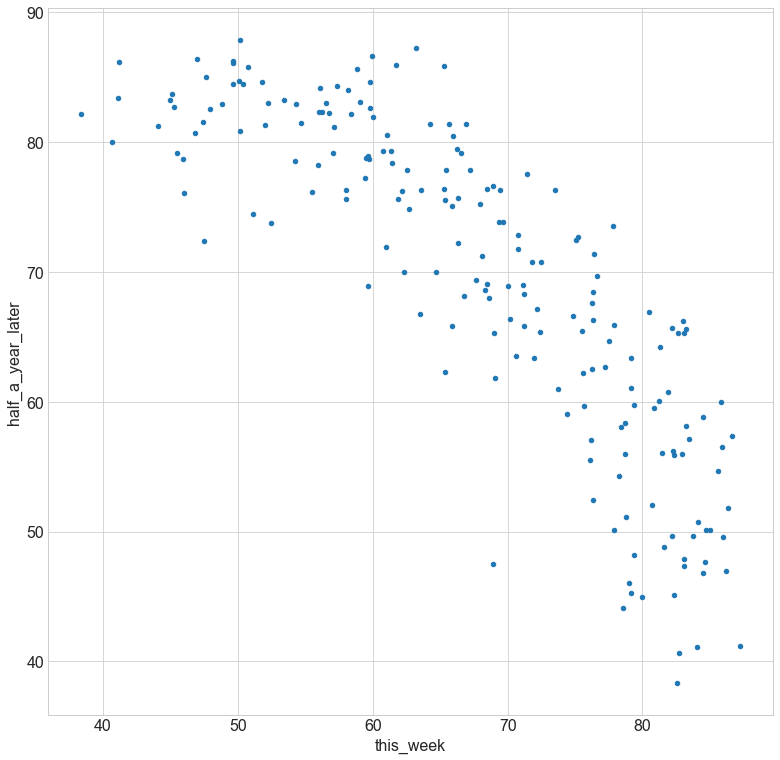

In [22]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['half_a_year_later'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 13))
weekly

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

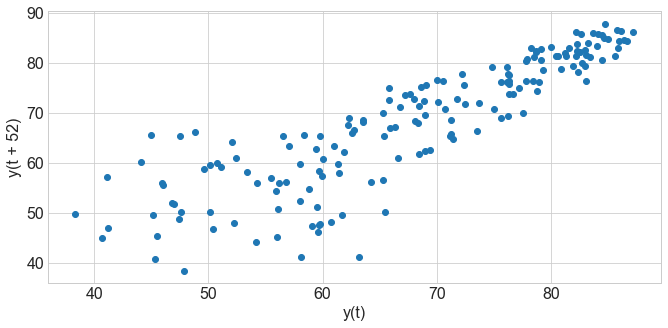

In [23]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=52)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 156)'>

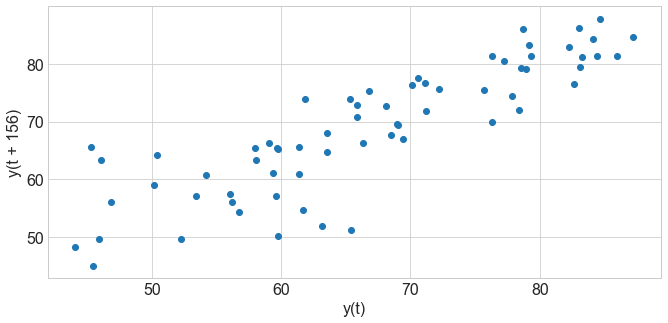

In [24]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=156) # 156 -- three years out

### 8 Autocorrelation Plot

- What is pearson's r as a function of the lag time?
- **autocorrelation**: a series correlation with itself
- can help to identify seasonality

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

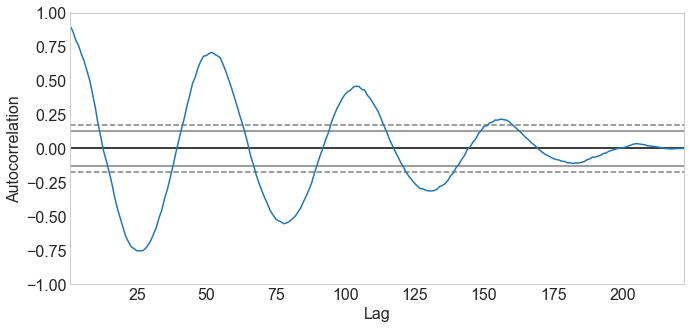

In [25]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

### 9 Seasonal Decomposition

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

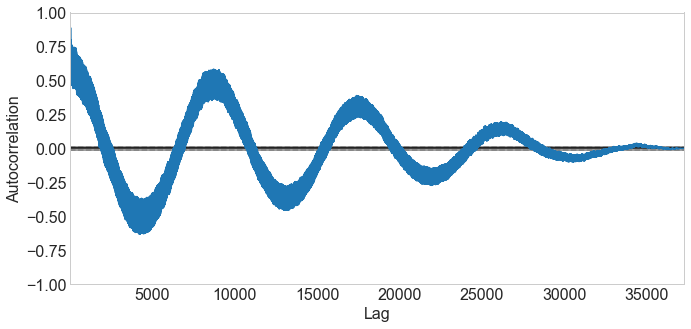

In [26]:
pd.plotting.autocorrelation_plot(y)

In [27]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

<AxesSubplot:xlabel='datetime'>

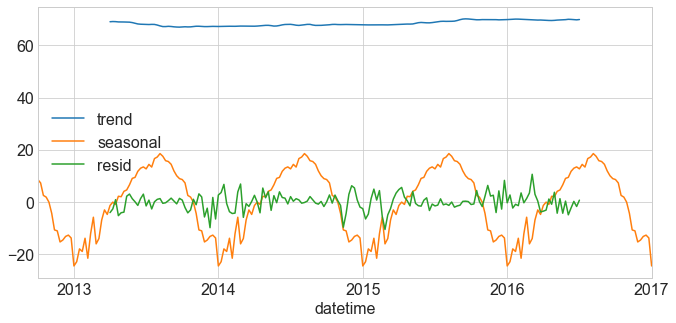

In [28]:
decomposition.iloc[:, 1:].plot()

Additive seasonal decomposition model:

$$ y_t = S_t + T_t + R_t $$

multiplicative model

$$ y_t = S_t \times T_t \times R_t $$

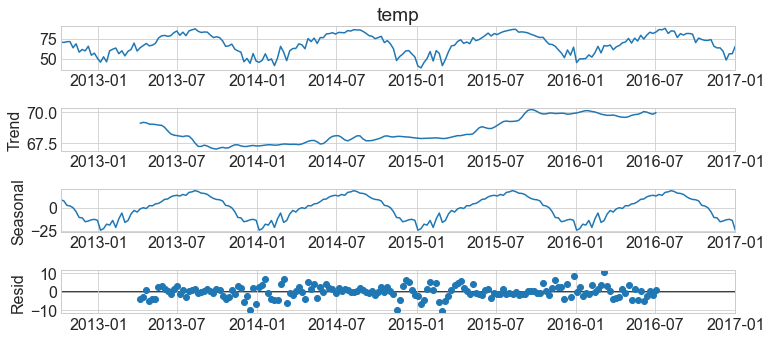

In [29]:
result.plot()
None

### 10 Area Plots

- can we visualize categories over time?

In [30]:
train = train.drop(columns='y(t + 1)')

In [31]:
train = train.resample('D').mean()

In [32]:
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])

In [33]:
train.groupby('temp_bin').mean()

,temp
temp_bin,
cold,49.381699
cool,65.200219
warm,75.447977
hot,83.449087


How is the distribution of temp_bin changing over time?

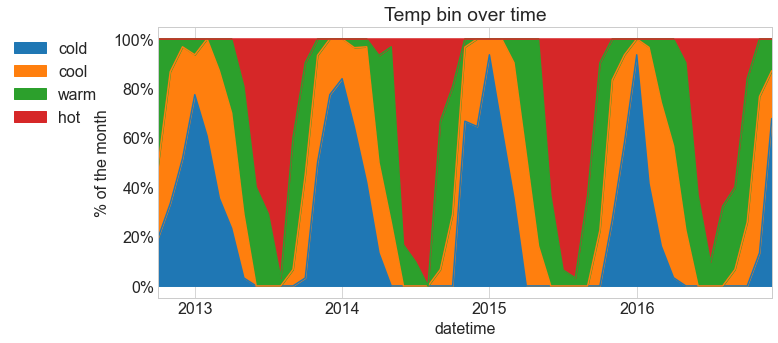

In [34]:
ax = (train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area(title='Temp bin over time', ylabel='% of the month'))
ax.legend(loc="upper right", bbox_to_anchor=(-.075, 1))
ax.yaxis.set_major_formatter('{:.0%}'.format)

## `strftime`

[Cheatsheet](https://zgulde.net/strftime.html) or `man strftime`

In [35]:
train.index.strftime('%w-%A')

Index(['1-Monday', '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday',
       '6-Saturday', '0-Sunday', '1-Monday', '2-Tuesday', '3-Wednesday',
       ...
       '4-Thursday', '5-Friday', '6-Saturday', '0-Sunday', '1-Monday',
       '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday', '6-Saturday'],
      dtype='object', name='datetime', length=1553)

In [36]:
df.head(5).index.strftime('The date is %B %d, %Y and the time is %I:%M %p')

Index(['The date is October 01, 2012 and the time is 01:00 PM',
       'The date is October 01, 2012 and the time is 02:00 PM',
       'The date is October 01, 2012 and the time is 03:00 PM',
       'The date is October 01, 2012 and the time is 04:00 PM',
       'The date is October 01, 2012 and the time is 05:00 PM'],
      dtype='object', name='datetime')

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

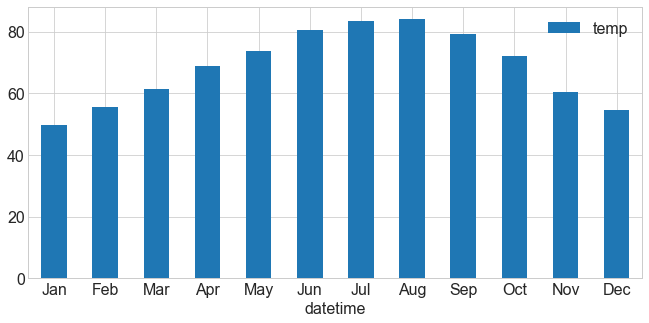

In [37]:
ax = train.groupby(train.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)

See also: pd.Categorical

## Matplotlib Dates

In [38]:
from matplotlib.dates import DateFormatter, MonthLocator

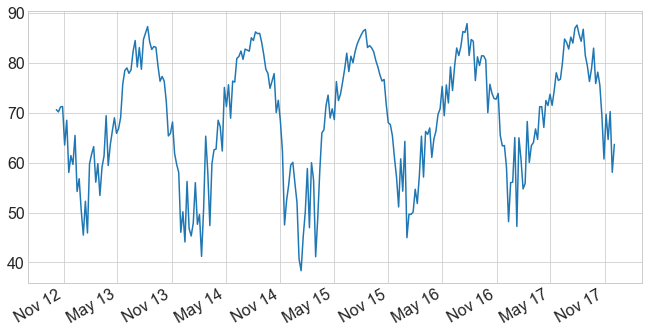

In [39]:
fig, ax = plt.subplots()

weekly = df.temp.resample('W').mean()

x = weekly.index
y = weekly.values

ax.plot(x, y)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_major_locator(MonthLocator(interval=6))
ax.tick_params(axis='x', rotation=30)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_ha('right')